In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import tensorflow as tf
from sklearn import metrics
import tensorflow_hub as hub
import numpy as np

In [7]:
def show_image(cur_dir):
    df = pd.DataFrame(columns=["id","label"])
    data_directory = os.listdir(cur_dir)
    for image_directory in data_directory:
        apparel_list = image_directory
        for image in os.listdir(cur_dir+"/"+image_directory):
            df = df.append({'id':cur_dir+"/"+image_directory+"/"+image,'label':apparel_list},ignore_index=True)
    return df

In [8]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
data = show_image("/content/drive/")
data = show_image("/content/drive/MyDrive/Colab Notebooks/NNDL/apparel")

In [10]:
# data = pd.read_csv("csv/images_labels.csv")
data.tail()

,id,label
16296,/content/drive/MyDrive/Colab Notebooks/NNDL/ap...,black_shirt
16297,/content/drive/MyDrive/Colab Notebooks/NNDL/ap...,black_shirt
16298,/content/drive/MyDrive/Colab Notebooks/NNDL/ap...,black_shirt
16299,/content/drive/MyDrive/Colab Notebooks/NNDL/ap...,black_shirt
16300,/content/drive/MyDrive/Colab Notebooks/NNDL/ap...,black_shirt


In [11]:
apparel_list = data["label"].unique()

In [12]:
data_label = data["label"].to_numpy()
data_label

array(['white_shoes', 'white_shoes', 'white_shoes', ..., 'black_shirt',
       'black_shirt', 'black_shirt'], dtype=object)

In [13]:
boolean_data_label = [label == apparel_list for label in data_label]
boolean_data_label[:3]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])]

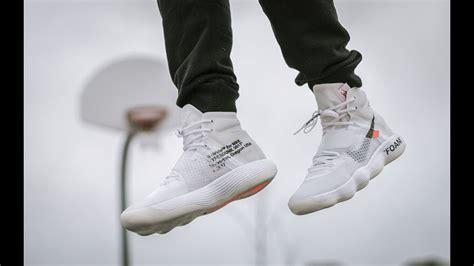

In [14]:
from IPython.display import Image

img_path = data["id"][1]
Image(img_path,width=300,height=300)

In [15]:
X = list(data["id"].values)
y = boolean_data_label

In [16]:
from sklearn.model_selection import train_test_split
train_ratio = 0.65
validation_ratio = 0.05
test_ratio = 0.3

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=test_ratio/(test_ratio + validation_ratio))

In [17]:
from matplotlib.pyplot import imread

image = imread(X_train[42])
image.shape

(466, 474, 3)

In [18]:
image.min(),image.max()

(0, 255)

In [19]:
IMG_SIZE = 224

def process_image(image_path,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
    image = tf.io.read_file(image_path) # Read image file
    image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
    image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
    image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    return image 

In [20]:
def get_image_label(image_path,label):
    """
    Take an image file path name and the associated label,
    process the image and return a tuple of (image,label)
    """
    image = process_image(image_path)
    return image,label

In [21]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False,train_data=False):
    """
    Create batches of data out of image (X) and lebel (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is valid dataset, we don't have to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    elif train_data:
        print("Creating Training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [22]:
# Create training and validation data batches
test_data = create_data_batches(X=X_test,y=y_test)
val_data = create_data_batches(X=X_val,y=y_val,valid_data=True)
train_data = create_data_batches(X=X_train,y=y_train,train_data=True)

Creating training data batches...
Creating validation data batches...
Creating Training data batches...


In [23]:
import matplotlib.pyplot as plt

def show_25_images(images,labels,predicted):
    """
    Display a plot of 25 images and their labels from a batch.
    """
    plt.figure(figsize=(15,10))
    for i in range(25):
        if apparel_list[labels[i].argmax()] == apparel_list[predicted[i].argmax()]:
            color = 'blue'
        else:
            color = 'red'
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(apparel_list[labels[i].argmax()],color=color)
        plt.axis("off")

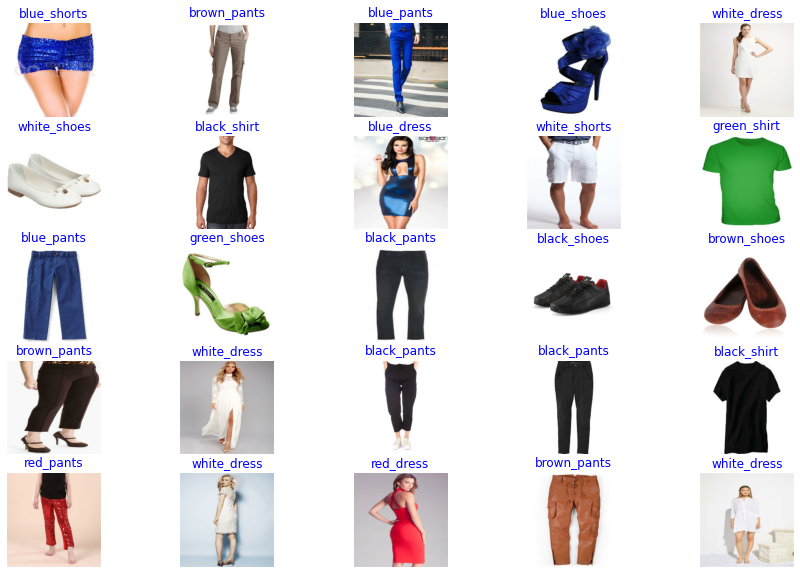

In [24]:
train_images,train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels,train_labels)

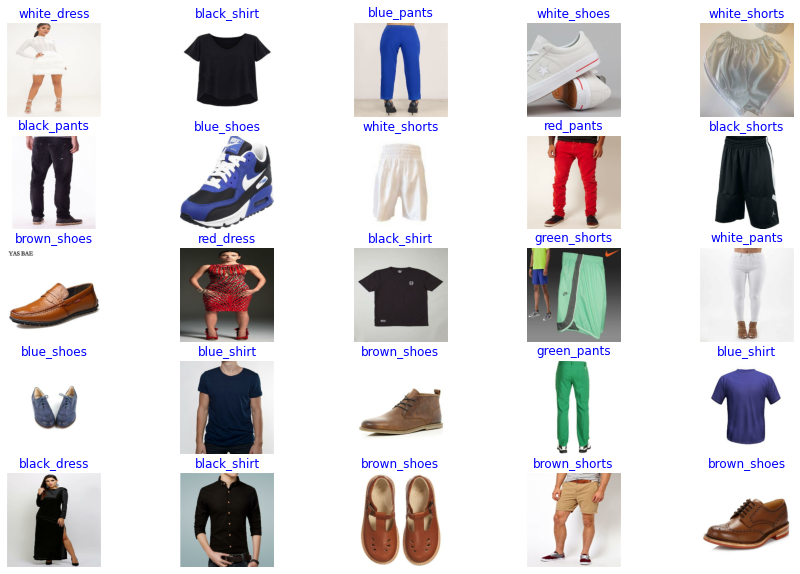

In [25]:
val_images,val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels,val_labels)

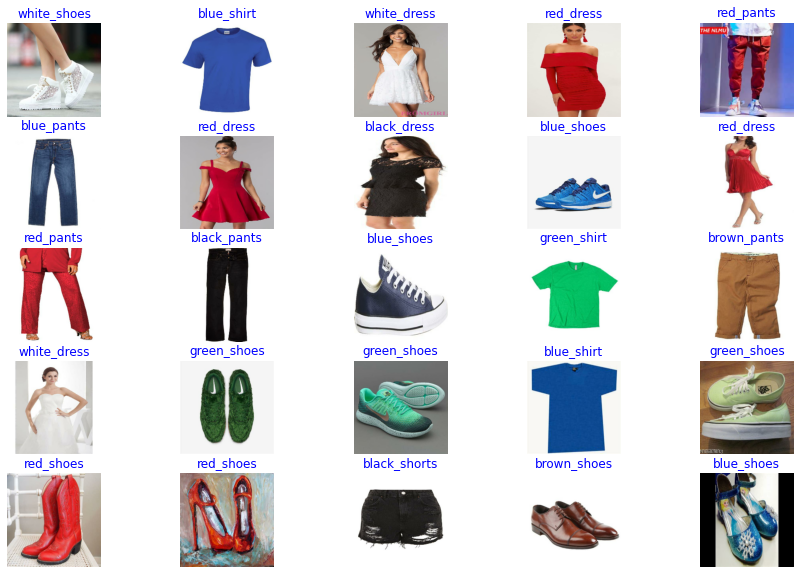

In [26]:
test_image,test__labels = next(test_data.as_numpy_iterator())  
show_25_images(test_image,test__labels,test__labels)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [28]:
train_images.shape

(32, 224, 224, 3)

In [29]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = 24
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    print(f"Building model with: {model_url}")
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1: MODEL LAYER
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")]) # Layer 2: Output layer
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(), #optimizer
        metrics=["accuracy"])
    model.build(input_shape)
    return model

In [30]:
import datetime
def create_tensorboard_callback():
    logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
NUM_EPOCHS = 5

In [32]:
def train_model():
    """
    Train a given model and return the trained version.
    """
    model = create_model() # Create a model
    model.summary()
    tensorboard = create_tensorboard_callback() # Create tensorboard callback
    history = model.fit(x=train_data,
              epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping]) # Fit the model passing it the callback we created
    return model,history

In [33]:
model,history = train_model()

Building model with: https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25612201  
                                                                 
 dense (Dense)               (None, 24)                24048     
                                                                 
Total params: 25,636,249
Trainable params: 24,048
Non-trainable params: 25,612,201
_________________________________________________________________
Epoch 1/5
284/284 [==============================] - 2484s 9s/step - loss: 1.0614 - accuracy: 0.6642 - val_loss: 0.6072 - val_accuracy: 0.8037
Epoch 2/5
284/284 [==============================] - 1418s 5s/step - loss: 0.5020 - accuracy: 0.8336 - val_loss: 0.4933 - val_accuracy: 0.8453
Epoch 3/5
284/284 [==============================] - 1475s 5s/st

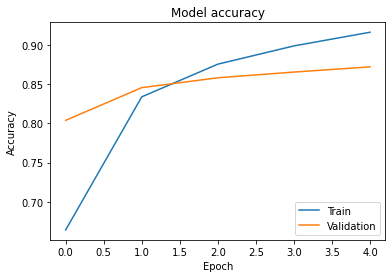

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

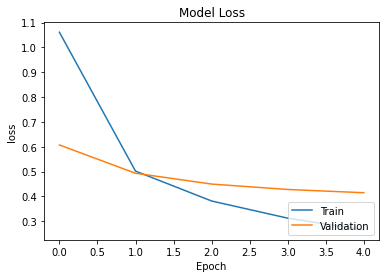

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [36]:
print(f'Akurasi Validations: {history.history["val_accuracy"][-1]*100:.2f}%')
print(f'Rata-rata akurasi validation: {np.mean(history.history["val_accuracy"])*100:.2f}%')
print(model.evaluate(test_data))

Akurasi Validations: 87.18%
Rata-rata akurasi validation: 84.88%
179/179 [==============================] - 1498s 8s/step - loss: 0.4185 - accuracy: 0.8566
[0.4185364544391632, 0.8566421270370483]


In [37]:
def show_model_accuracy(X_train, X_test, y_train, y_test):
    test_predicted = model.predict(test_data)
    list_predicted = [l.argmax() for l in np.round(test_predicted)]
    list_y_test = [l.argmax() for l in y_test]
    print('====================== Accuracy =======================')
    print(f'Precision\t: {metrics.precision_score(list_y_test, list_predicted, average="macro") } %')
    print(f'F1 score\t: {metrics.f1_score(list_y_test, list_predicted, average="macro") } %')
    print(f'Recall\t\t: {metrics.recall_score(list_y_test, list_predicted, average="macro") } %')
    print(f'Akurasi Test\t: {model.evaluate(test_data)[1]*100:.2f}%')
    print('=======================================================')
show_model_accuracy(X_train, X_test, y_train, y_test)

179/179 [==============================] - 761s 4s/step
====================== Accuracy =======================
Precision	: 0.04238014042510437 %
F1 score	: 0.042103421673683195 %
Recall		: 0.04310898294381871 %
179/179 [==============================] - 756s 4s/step - loss: 0.4185 - accuracy: 0.8566
Akurasi Test	: 85.66%


In [ ]:
model.save("models/apparel-classification.h5")

In [39]:
model = tf.keras.models.load_model("models/apparel-classification.h5",custom_objects={'KerasLayer':hub.KerasLayer})

In [40]:
test_predicted = model.predict(test_data)

179/179 [==============================] - 768s 4s/step


In [ ]:
list_predicted = [l.argmax() for l in np.round(test_predicted)]
list_y_test = [l.argmax() for l in y_test]

In [45]:
from sklearn.metrics import accuracy_score
print(f'Accuracy Score:\t{accuracy_score(list_predicted,list_y_test) * 100:.2f} %')

Accuracy Score:	5.15 %


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_y_test,list_predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='.0f',cmap='Oranges') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(list(apparel_list)) ax.yaxis.set_ticklabels(list(apparel_list))

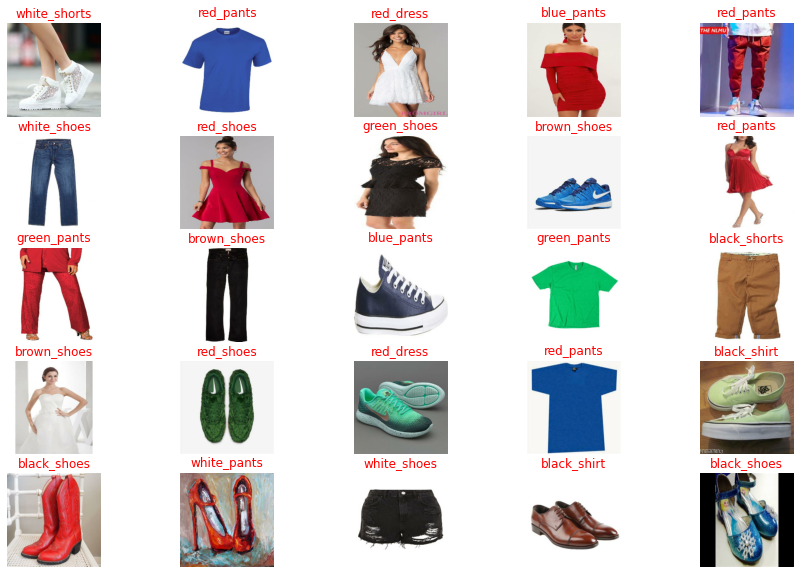

In [44]:
# Show the image along with the labels of test dataset
# If its label is blue, the prediction is correct
# If its label is red, the prediction is incorrect
show_25_images(test_image,y_test,test_predicted)